In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.applications import VGG19
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense 
from tensorflow.keras.regularizers import l2


In [19]:
# Now lets load the data
image_directory='/Users/lovishmiglani/archive (2)'
no_tumor_images=os.listdir(image_directory+ '/no')
yes_tumor_images=os.listdir(image_directory+ '/yes')

print('No Tumor: ', len(no_tumor_images))
print('Tumor: ',len(yes_tumor_images))

No Tumor:  1500
Tumor:  1502


In [20]:
dataset=[]
label=[]

In [21]:
# Creating label for brain not having tumor
for image_name in no_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'no', image_name)
        
        # Check if the image file exists
        if os.path.exists(image_path):
            # Read the image using cv2
            image = cv2.imread(image_path)
            
            # Check if the image is successfully read
            if image is not None:
                image = cv2.imread(image_path)
                # Convert the image to an RGB PIL Image
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                
                # Resize the image
                INPUT_SIZE = (64,64)
                image = image.resize(INPUT_SIZE)
                
                # Append the image to the dataset
                dataset.append(np.array(image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(0)

In [22]:
# Creating label for brain having tumor

for image_name in yes_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'yes', image_name)
        
        # Check if the image file exists
        if os.path.exists(image_path):
            # Read the image using cv2
            image = cv2.imread(image_path)
            
            # Check if the image is successfully read
            if image is not None:
                # Convert the image to an RGB PIL Image
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                
                # Resize the image
                INPUT_SIZE = (64,64)
                image = image.resize(INPUT_SIZE)
                
                # Append the image to the dataset
                dataset.append(np.array(image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(1)

In [23]:
# Convert labels to a numpy array
label = [0] * len(no_tumor_images) + [1] * len(yes_tumor_images)
label=np.array(label)
dataset=np.array(dataset)
# print('label array', label)
# print('dataset array', dataset)

print('Dataset: ',len(dataset))
print('Label: ',len(label))

Dataset:  3001
Label:  3002


In [27]:
# Assuming label is a list or array
dataset= dataset[:3000]
label = label[:3000]  # Keep only the first 3000 labels

# Now, you can proceed with the train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2023)




In [28]:
#standardization
X_train = normalize(X_train, axis=0)
# print(X_train)
X_test = normalize(X_test, axis=0)
# print(X_test)


In [29]:
# Get the pretrained VGG19 model 
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the pretrained VGG19 layers
for layer in vgg19.layers:
    layer.trainable = False
    
# Add classification layers
x = vgg19.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

# Create the full model
model = Model(inputs=vgg19.input, outputs=predictions)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False
)

Epoch 1/100
75/75 [==============================] - 93s 1s/step - loss: 0.7289 - accuracy: 0.6196 - val_loss: 0.6128 - val_accuracy: 0.6633
Epoch 2/100
75/75 [==============================] - 80s 1s/step - loss: 0.6061 - accuracy: 0.6800 - val_loss: 0.6455 - val_accuracy: 0.6267
Epoch 3/100
75/75 [==============================] - 81s 1s/step - loss: 0.5827 - accuracy: 0.7121 - val_loss: 0.6720 - val_accuracy: 0.5950
Epoch 4/100
75/75 [==============================] - 80s 1s/step - loss: 0.5792 - accuracy: 0.7067 - val_loss: 0.7150 - val_accuracy: 0.6167
Epoch 5/100
75/75 [==============================] - 76s 1s/step - loss: 0.5689 - accuracy: 0.7188 - val_loss: 0.7349 - val_accuracy: 0.5700
Epoch 6/100
75/75 [==============================] - 101s 1s/step - loss: 0.5569 - accuracy: 0.7225 - val_loss: 0.7621 - val_accuracy: 0.5933
Epoch 7/100
75/75 [==============================] - 85s 1s/step - loss: 0.5566 - accuracy: 0.7204 - val_loss: 0.7556 - val_accuracy: 0.5967
Epoch 8/100


In [31]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print("Test Accuracy:", test_accuracy)

19/19 - 8s - loss: 0.6323 - accuracy: 0.6517 - 8s/epoch - 428ms/step
Test Accuracy: 0.6516666412353516


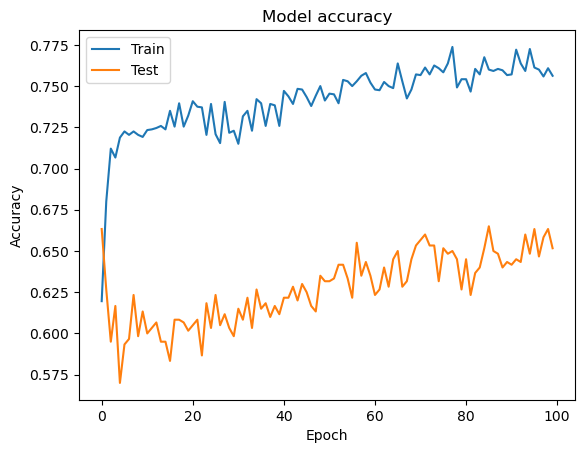

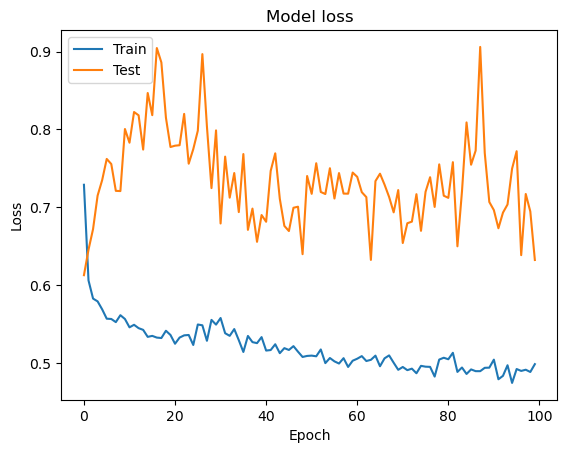

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('BrainTumorDetec.h5')

In [ ]:
model = load_model('/Users/lovishmiglani/BrainTumorDetec.h5')

In [ ]:
def make_prediction(img):
    
#     input_img = image.img_to_array(img)
    input_img = np.expand_dims(img, axis=0)
#     pp_image = preprocess_input(input_img)
    
    res = (model.predict(input_img) > 0.5).astype("int32")
    return res

In [ ]:
def show_result(img):
    img_path = os.path.join(image_directory, 'pred', img)
    
    # Check if the image file exists
    if os.path.exists(img_path):
        # Read the image using cv2
        image = cv2.imread(img_path)
        
        # Check if the image is successfully read
        if image is not None:
            # Convert the image to an RGB PIL Image
            img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            # Resize the image
            img = img.resize((64, 64))
            
            # Convert the image back to a numpy array if needed
            img = np.array(img)
            
            plt.imshow(img)
            plt.show()
    
            pred = make_prediction(img)
            if pred:
                print("Tumor Detected")
            else:
                print("No Tumor")

In [ ]:
show_result('pred29.jpg')
